In [ ]:
! pip install transformers

In [1]:
from transformers import (
    Trainer,
    BertTokenizer,
    AutoTokenizer,
    BertConfig,
    BertModel,
)
import transformers
import numpy as np
import pandas as pd
import stanza

import os
import random
import time
import math
import yaml
import dill as pickle
from typing import *
from datetime import datetime
from collections import namedtuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# Display the entire text
pd.set_option("display.max_colwidth", None)

In [2]:
# stanza.download('en', processors='tokenize,pos')
# stanza.download(lang="en",package=None,processors={"ner":"ontonotes"})
# stanza.download('en', processors='constituency')

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

model_name_or_path = "bert-base-cased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
curr_location = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/hw3/stud/"
os.chdir(curr_location)

In [5]:
from arguments import CustomTrainingArguments

In [6]:
train_clean_path = "../../model/data/train_clean.tsv"
valid_clean_path = "../../model/data/valid_clean.tsv"

In [7]:
df_train = pd.read_csv(filepath_or_buffer=train_clean_path, sep="\t")
df_valid = pd.read_csv(filepath_or_buffer=valid_clean_path, sep="\t")

Is a token classification: for each token I need to say if it is ambiguous or not. 

In [6]:
# I should introduce a mention tag for the pronoun

In [7]:
FEMININE = 0
MASCULINE = 1
UNKNOWN = 2

def get_gender(pronoun: str):
    gender_mapping = {
        'she': FEMININE,
        'her': FEMININE,
        'he': MASCULINE,
        'his': MASCULINE,
        'him': MASCULINE,
    }

    return gender_mapping.get(pronoun.lower(), UNKNOWN)

# For training don't consider neither

In [8]:
class GAP_AmbiguousDetection_Dataset(Dataset):
    """Custom GAP Dataset class"""

    def __init__(self, df, tokenizer, stanza_processor, tag_labels, labeled=True):
        self.df = df

        self.labeled = labeled
        self.tokenizer = tokenizer
        self.stanza_processor = stanza_processor
        self.tag_labels = tag_labels
        
        self.samples = []
        self._convert_tokens_to_ids()
        
        
    def _assign_class_to_tokens(self, entities_offsets, coreferent_ent_offset):
        labels = []
        for offset in entities_offsets:
            if coreferent_ent_offset is not None and offset == coreferent_ent_offset[0]:
                labels.append(2)
            else:
                labels.append(1)
                
        return labels  
        
    def _convert_tokens_to_ids(self):
        CLS = [self.tokenizer.cls_token]
        SEP = [self.tokenizer.sep_token]
        
        tag_labels = self.tag_labels
        pronoun_tag = tag_labels['pronoun_tag']
        start_entity_tag = tag_labels['start_entity_tag']
        end_entity_tag = tag_labels['end_entity_tag']
        start_coref_entity_tag = tag_labels['start_coref_entity_tag']
        end_coref_entity_tag = tag_labels['end_coref_entity_tag']
        
        Sample = namedtuple("Sample", ['tokens', 'start_entities_offsets', 'end_entities_offsets', 'coreferent_ent_offset', 'ambiguous_pron_offset'])
        if self.labeled:
            Sample = namedtuple("Sample", Sample._fields + ("labels",))

        for _, row in self.df.iterrows():
            coreferent_ent_offset_tuple = None
            tokens, entities_offsets = self.tokenize(row)
            tokens_to_convert = CLS + tokens + SEP
            sample = {'tokens': self.tokenizer.convert_tokens_to_ids(tokens_to_convert)}
            
            # Because of the introduction of CLS we have to add 1 to the offsets
            if entities_offsets[pronoun_tag]:
                sample['ambiguous_pron_offset'] = entities_offsets[pronoun_tag][0] + 1
            if entities_offsets[start_coref_entity_tag]:
                coreferent_ent_offset_tuple = (entities_offsets[start_coref_entity_tag][0] + 1, 
                                               entities_offsets[end_coref_entity_tag][0] + 1)
 
            sample['coreferent_ent_offset'] = coreferent_ent_offset_tuple

            start_entities_offsets = [off + 1 for off in entities_offsets[start_entity_tag]]
            end_entities_offsets = [off + 1 for off in entities_offsets[end_entity_tag]]

            
            # all_entities_offsets = list(zip([off + 1 for off in entities_offsets[start_entity_tag]], 
            #                                 [off + 1 for off in entities_offsets[end_entity_tag]]))

            if coreferent_ent_offset_tuple is not None:
                # Add coreferent mention offsets
                start_entities_offsets = sorted(start_entities_offsets + [coreferent_ent_offset_tuple[0]])
                end_entities_offsets = sorted(end_entities_offsets + [coreferent_ent_offset_tuple[1]])
                # all_entities_offsets = sorted(all_entities_offsets + [coreferent_ent_offset_tuple])
            
            # sample['all_entities_offsets'] = all_entities_offsets
            sample['start_entities_offsets'] = start_entities_offsets
            sample['end_entities_offsets'] = end_entities_offsets
            


            if self.labeled:
                # sample['labels'] = self._assign_class_to_tokens(all_entities_offsets, coreferent_ent_offset_tuple)
                sample['labels'] = self._assign_class_to_tokens(start_entities_offsets, coreferent_ent_offset_tuple)

            sample_namedtuple = Sample(**sample)
            self.samples.append(sample_namedtuple)
    
    @staticmethod
    def get_coreferent_entity_offset(row):
        not_coref_A = row["is_coref_A"] in ["FALSE", False]
        not_coref_B = row["is_coref_B"] in ["FALSE", False]
        if not_coref_A and not_coref_B:
            return -1
        is_coref_A = row["is_coref_A"] in ["TRUE", True]
        return row["offset_A"] if is_coref_A else row["offset_B"]
    
    def _delimit_entities(self, row):
        
        text = row['text']
        pronoun_offset = row['p_offset']

        coreferent_entity_offset = -1
        if self.labeled:
            coreferent_entity_offset = self.get_coreferent_entity_offset(row)
        
        # Parse the text using 'stanza'
        doc_processed = self.stanza_processor(text)
        
        tag_labels = self.tag_labels
        pronoun_tag = tag_labels['pronoun_tag']
        start_entity_tag = tag_labels['start_entity_tag']
        end_entity_tag = tag_labels['end_entity_tag']
        start_coref_entity_tag = tag_labels['start_coref_entity_tag']
        end_coref_entity_tag = tag_labels['end_coref_entity_tag']
         
#         offsets = []
        count_entities = 0

        # Insert pronoun tag
        text = self._insert_tag(text, (pronoun_offset, None), pronoun_tag)

        # Number of characters inserted to delimit an entity
        len_tags = len(start_entity_tag) + len(end_entity_tag)

        for ent in doc_processed.ents:
            if ent.type == "PERSON":
                # For every tag inserted we have to shift the offsets by the tag length
                start_off = ent.start_char + len_tags*count_entities
                end_off = ent.end_char + len_tags*count_entities

                
                # Because of the new tags, also the pronoun and the coreferent entity offsets are shifted
                current_coreferent_entity_offset = coreferent_entity_offset + len_tags*count_entities
                current_pronoun_offset = pronoun_offset + len_tags*count_entities
                if start_off > current_pronoun_offset:
                    start_off += len(pronoun_tag)
                    end_off += len(pronoun_tag)
                    current_coreferent_entity_offset += len(pronoun_tag)

#                 offsets.append((start_off, end_off))
                
                # In order to identify the coreferent entity, I use special tags
                if coreferent_entity_offset != -1 and start_off == current_coreferent_entity_offset:
                    text = self._insert_tag(text, (start_off, end_off), start_coref_entity_tag, end_coref_entity_tag)

                else:
                    text = self._insert_tag(text, (start_off, end_off), start_entity_tag, end_entity_tag)
                
                count_entities += 1
        
        return text
        

    def _insert_tag(self, text, offsets, start_tag: str, end_tag: str = None):
        start_off, end_off = offsets 

        # Starting tag only
        if end_tag is None:
            text = text[:start_off] + start_tag + text[start_off:]
            return text

        text = text[:start_off] + start_tag + text[start_off:end_off] + end_tag + text[end_off:]
        return text
    
    
    def tokenize(self, row):
        final_tokens = []
        tag_labels = self.tag_labels
        entities_offsets = {tag: [] for tag in tag_labels.values()}
        
        start_entity_tag = tag_labels['start_entity_tag']
        end_entity_tag = tag_labels['end_entity_tag']
        start_coref_entity_tag = tag_labels['start_coref_entity_tag']
        end_coref_entity_tag = tag_labels['end_coref_entity_tag']


        text = self._delimit_entities(row)
        
        for token in self.tokenizer.tokenize(text):       
            if token in [*tag_labels.values()]:
                entities_offsets[token].append(len(final_tokens)) 
                continue
            
            # Replace the special tags with the general entity tags 
            if token == start_coref_entity_tag:
                final_tokens.append(start_entity_tag)

            elif token == end_coref_entity_tag:
                final_tokens.append(end_entity_tag)

            else:
                final_tokens.append(token)

        return final_tokens, entities_offsets

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [162]:
df_train_neither_ent = df_train.loc[(df_train['is_coref_A'] == False) & (df_train['is_coref_B'] == False)]
# df_train_trues = df_train.loc[(df_train['is_coref_A'] == True) | (df_train['is_coref_B'] == True)]
# df_valid_trues = df_valid.loc[(df_valid['is_coref_A'] == True) | (df_valid['is_coref_B'] == True)]

In [217]:
# df_train_neither_ent

In [9]:
tag_labels = {
    "pronoun_tag": "<P>",
    "start_entity_tag": "<E>",
    "end_entity_tag": "</E>",
    "start_coref_entity_tag": "<C>",
    "end_coref_entity_tag": "</C>"
}

In [10]:
model_name_or_path = "../../model/tokenizer/"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
stanza_processor = stanza.Pipeline(lang='en', processors='tokenize,ner')

2022-08-27 10:38:57 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-08-27 10:38:57 INFO: Use device: gpu
2022-08-27 10:38:57 INFO: Loading: tokenize
2022-08-27 10:39:00 INFO: Loading: ner
2022-08-27 10:39:00 INFO: Done loading processors!


In [17]:
train_ds = GAP_AmbiguousDetection_Dataset(df_train[:50], tokenizer, stanza_processor, tag_labels)
valid_ds = GAP_AmbiguousDetection_Dataset(df_valid[:30], tokenizer, stanza_processor, tag_labels)

In [11]:
train_ds_save_path = "../../model/datasets/train_no_tags.ds"
valid_ds_save_path = "../../model/datasets/valid_no_tags.ds"


In [12]:
# with open(train_ds_save_path, 'wb') as file:
#     pickle.dump(train_ds, file)

In [13]:
# with open(valid_ds_save_path, 'wb') as file:
#     pickle.dump(valid_ds, file)

In [14]:
with open(train_ds_save_path, 'rb') as file:
    train_ds = pickle.load(file)

with open(valid_ds_save_path, 'rb') as file:
    valid_ds = pickle.load(file)

In [12]:
idx = 6
sent = df_train['text'][idx]
sent

"Reb Chaim Yaakov's wife is the sister of Rabbi Moishe Sternbuch, as is the wife of Rabbi Meshulam Dovid Soloveitchik, making the two Rabbis his uncles. Reb Asher's brother Rabbi Shlomo Arieli is the author of a critical edition of the novallae of Rabbi Akiva Eiger. Before his marriage, Rabbi Arieli studied in the Ponevezh Yeshiva headed by Rabbi Shmuel Rozovsky, and he later studied under his father-in-law in the Mirrer Yeshiva."

In [47]:
df_train.iloc[idx]

id                                                                                                                                                                                                                                                                                                                                                                                                                                               train-1
text          Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
pron                                                                                                                  

In [53]:
for i in range(len(train_ds)):
    if len(train_ds[i].labels) == 0:
        print(i)

162
1281
1730
2309
2472
2592


In [99]:
sent[209:]

'Lemhouse entered school to pursue a degree in Visual Communications (Graphic Design). Upon finishing school he started Lemhouse Design.'

In [71]:
train_ds[idx]

Sample(tokens=[101, 3414, 4934, 1968, 1144, 1145, 1125, 4374, 3573, 1107, 1199, 1476, 2441, 117, 1259, 7206, 3089, 1399, 117, 4266, 1399, 113, 2679, 114, 117, 21129, 113, 2678, 114, 117, 1109, 8947, 1183, 10341, 113, 2573, 114, 117, 12050, 1106, 9322, 2706, 113, 2573, 114, 117, 19869, 112, 18653, 1693, 113, 2477, 114, 117, 1109, 2896, 12853, 2772, 113, 2424, 114, 117, 3369, 112, 5581, 113, 2449, 114, 117, 1109, 1130, 118, 12077, 113, 2333, 114, 117, 2185, 1335, 1752, 27400, 1162, 113, 2253, 114, 117, 1109, 4254, 20092, 3291, 4455, 1513, 1107, 1738, 113, 2253, 114, 117, 1422, 17037, 2772, 113, 2278, 114, 117, 1109, 5135, 1104, 9859, 13335, 7008, 113, 1997, 114, 1105, 138, 3921, 20840, 113, 1630, 114, 119, 2611, 1107, 29000, 1123, 1578, 117, 1131, 1310, 3679, 3176, 119, 102], start_entities_offsets=[], end_entities_offsets=[], coreferent_ent_offset=None, ambiguous_pron_offset=125, labels=[])

In [41]:
tokenizer.convert_ids_to_tokens(1123)

'her'

In [18]:
def insert_tag(text, offsets, start_tag: str, end_tag: str = None):
    start_off, end_off = offsets 

    # Starting tag only
    if end_tag is None:
        text = text[:start_off] + start_tag + text[start_off:]
        return text

    text = text[:start_off] + start_tag + text[start_off:end_off] + end_tag + text[end_off:]
    return text

In [92]:
text = sent
pronoun_offset = df_train['p_offset'][idx]
coref_ds = df_train.iloc[idx]
coreferent_entity_offset = GAP_AmbiguousDetection_Dataset.get_coreferent_entity_offset(coref_ds)
# coreferent_entity_offset = -1
# Parse the text using 'stanza'
doc_processed = stanza_processor(text)

pronoun_tag = tag_labels['pronoun_tag']
start_entity_tag = tag_labels['start_entity_tag']
end_entity_tag = tag_labels['end_entity_tag']
start_coref_entity_tag = tag_labels['start_coref_entity_tag']
end_coref_entity_tag = tag_labels['end_coref_entity_tag']
    
#         offsets = []
count_entities = 0

# Insert pronoun tag
text = insert_tag(text, (pronoun_offset, None), pronoun_tag)

# Number of characters inserted to delimit an entity
len_tags = len(start_entity_tag) + len(end_entity_tag)
doc_processed = stanza_processor(sent)

for ent in doc_processed.ents:
    if ent.type == "PERSON":
        # For every tag inserted we have to shift the offsets by the tag length
        start_off = ent.start_char + len_tags*count_entities
        end_off = ent.end_char + len_tags*count_entities

        
        # Because of the new tags, also the pronoun and the coreferent entity offsets are shifted
        current_coreferent_entity_offset = coreferent_entity_offset + len_tags*count_entities
        current_pronoun_offset = pronoun_offset + len_tags*count_entities
        if start_off > current_pronoun_offset:
            start_off += len(pronoun_tag)
            end_off += len(pronoun_tag)
            current_coreferent_entity_offset += len(pronoun_tag)

#                 offsets.append((start_off, end_off))
        
        # In order to identify the coreferent entity, I use special tags
        if coreferent_entity_offset != -1 and start_off == current_coreferent_entity_offset:
            text = insert_tag(text, (start_off, end_off), start_coref_entity_tag, end_coref_entity_tag)

        else:
            text = insert_tag(text, (start_off, end_off), start_entity_tag, end_entity_tag)
        
        count_entities += 1

text
        

"<E>Reb Chaim Yaakov's</E> wife is the sister of <E>Rabbi Moishe Sternbuch</E>, as is the wife of <E>Rabbi Meshulam Dovid Soloveitchik</E>, making the two Rabbis his uncles. <E>Reb Asher's</E> brother <E>Rabbi Shlomo Arieli</E> is the author of a critical edition of the novallae of <E>Rabbi Akiva Eiger</E>. Before <P>his marriage, <E>Rabbi Arieli</E> studied in the Ponevezh Yeshiva headed by <E>Rabbi Shmuel Rozovsky</E>, and he later studied under his father-in-law in the Mirrer Yeshiva."

In [20]:
# for e in doc_processed.ents:
#     print(e) if e.type == "ORG" else None

In [21]:
# print([(ent.text, ent.type )for ent in doc_processed.ents])

In [99]:
def tokenize(text):
    entities_offsets = {tag: [] for tag in tag_labels.values()}
    final_tokens = []
    
    start_entity_tag = tag_labels['start_entity_tag']
    end_entity_tag = tag_labels['end_entity_tag']
    start_coref_entity_tag = tag_labels['start_coref_entity_tag']
    end_coref_entity_tag = tag_labels['end_coref_entity_tag']

    
    for token in tokenizer.tokenize(text):
        # Replace the special tags with the general entity tags
        if token in [*tag_labels.values()]:
            # If end tag, append the index of previous token
#             if "/" in token:
#                 entities_offsets[token].append(len(final_tokens) - 1)

#             else:
            entities_offsets[token].append(len(final_tokens))
                
            continue
                
        if token == start_coref_entity_tag:
            final_tokens.append(start_entity_tag)

        elif token == end_coref_entity_tag:
            final_tokens.append(end_entity_tag)

        else:
            final_tokens.append(token)

    print(final_tokens, entities_offsets)
    return final_tokens, entities_offsets

In [100]:
tokens, offsets = tokenize(text)

['Re', '##b', 'Cha', '##im', 'Ya', '##ak', '##ov', "'", 's', 'wife', 'is', 'the', 'sister', 'of', 'Rabbi', 'Mo', '##ish', '##e', 'Stern', '##bu', '##ch', ',', 'as', 'is', 'the', 'wife', 'of', 'Rabbi', 'Me', '##shu', '##lam', 'Do', '##vid', 'Solo', '##ve', '##itch', '##ik', ',', 'making', 'the', 'two', 'Rabbi', '##s', 'his', 'uncle', '##s', '.', 'Re', '##b', 'Asher', "'", 's', 'brother', 'Rabbi', 'S', '##hl', '##omo', 'Ariel', '##i', 'is', 'the', 'author', 'of', 'a', 'critical', 'edition', 'of', 'the', 'no', '##val', '##la', '##e', 'of', 'Rabbi', 'A', '##ki', '##va', 'E', '##iger', '.', 'Before', 'his', 'marriage', ',', 'Rabbi', 'Ariel', '##i', 'studied', 'in', 'the', 'Po', '##ne', '##vez', '##h', 'Yes', '##hiva', 'headed', 'by', 'Rabbi', 'S', '##hm', '##uel', 'R', '##oz', '##ovsky', ',', 'and', 'he', 'later', 'studied', 'under', 'his', 'father', '-', 'in', '-', 'law', 'in', 'the', 'Mir', '##rer', 'Yes', '##hiva', '.'] {'<P>': [81], '<E>': [0, 14, 27, 47, 53, 73, 84, 98], '</E>': [9, 21

In [98]:
tokens[113:121]

['<E>', 'Rabbi', 'S', '##hm', '##uel', 'R', '##oz', '##ovsky']

In [27]:
text

'<E>Killian</E> in 1978--79, an assistant district attorney for Brunswick Judicial Circuit in 1979--80, and a practicing attorney in Glynn County in 1980--90. <E>Williams</E> was elected a Superior Court judge in 1990, taking the bench in 1991. In November 2010 <C>Williams</C> competed against <E>Mary Helen Moses</E> in <P>her most recent bid for re-election.'

In [15]:
class Collator:
    def __init__(self, device, labeled=True):
        self.device = device
        self.labeled = labeled
        
    def __call__(self, batch, truncate_len=512):
        """Batch preparation.

        1. Pad the sequences
        2. Transform the target.
        """

        # ['tokens', 'all_entities_offsets', 'coreferent_ent_offset', 'ambiguous_pron_offset', 'labels']
        if self.labeled:
            batch_features, batch_start_entities_offsets, batch_end_entities_offsets, _, _, batch_labels = zip(*batch)
        
        else:
            batch_features, batch_start_entities_offsets, batch_end_entities_offsets, _, _ = zip(*batch)
        
        collate_sample = {}

        max_len_features_in_batch = self.compute_max_len(batch_features, truncate_len)
        max_len_offsets_in_batch = self.compute_max_len(batch_start_entities_offsets, truncate_len)

        # Features        
        padded_features = self.pad_sequence(batch_features, max_len_features_in_batch, 0)
        features_tensor = torch.tensor(padded_features, device=device)
        collate_sample['features'] = features_tensor

        # Offsets
        padded_start_entities_offsets = self.pad_sequence(batch_start_entities_offsets, max_len_offsets_in_batch, 0)
        start_entities_offsets_tensor = torch.tensor(padded_start_entities_offsets, device=device)
        # collate_sample['start_entities_offsets'] = start_entities_offsets_tensor

        padded_end_entities_offsets = self.pad_sequence(batch_end_entities_offsets, max_len_offsets_in_batch, 0)
        end_entities_offsets_tensor = torch.tensor(padded_end_entities_offsets, device=device)
        # collate_sample['end_entities_offsets'] = end_entities_offsets_tensor

        collate_sample['entities_offsets'] = list(zip(start_entities_offsets_tensor, end_entities_offsets_tensor))

        # Labels
        if not self.labeled:
            return collate_sample

        padded_labels = self.pad_sequence(batch_labels, max_len_offsets_in_batch, 0)
        labels_tensor = torch.tensor(padded_labels, dtype=torch.uint8, device=device)
        collate_sample['labels'] = labels_tensor
        
        return collate_sample
    
    @staticmethod
    def compute_max_len(sentences, truncate_len) -> int:
        # calculate the max sentence length in the dataset
        max_len = min(
            max((len(x) for x in sentences)),
            truncate_len
        )
        return max_len
    
    @staticmethod
    def pad_sequence(list_sequences: List[List[Any]], max_len: int, pad: int) -> List[Any]:
    
        features = np.full((len(list_sequences), max_len), pad, dtype=np.int64)

        # Padding
        for i, row in enumerate(list_sequences):
            features[i, :len(row)] = row

        return features

In [46]:
def collate(batch, labeled = True, truncate_len=512):
    # ['tokens', 'all_entities_offsets', 'coreferent_ent_offset', 'ambiguous_pron_offset', 'labels']
    if labeled:
        batch_features, batch_start_entities_offsets, batch_end_entities_offsets, _, _, batch_labels = zip(*batch)
    
    else:
        batch_features, batch_start_entities_offsets, batch_end_entities_offsets, _, _ = zip(*batch)
    
    collate_sample = {}

    max_len_features_in_batch = compute_max_len(batch_features, truncate_len)
    max_len_offsets_in_batch = compute_max_len(batch_start_entities_offsets, truncate_len)

    # Features        
    padded_features = pad_sequence(batch_features, max_len_features_in_batch, 0)
    features_tensor = torch.tensor(padded_features, device=device)
    collate_sample['features'] = features_tensor

    # Offsets
    padded_start_entities_offsets = pad_sequence(batch_start_entities_offsets, max_len_offsets_in_batch, 0)
    start_entities_offsets_tensor = torch.tensor(padded_start_entities_offsets, device=device)
    # collate_sample['start_entities_offsets'] = start_entities_offsets_tensor

    padded_end_entities_offsets = pad_sequence(batch_end_entities_offsets, max_len_offsets_in_batch, 0)
    end_entities_offsets_tensor = torch.tensor(padded_end_entities_offsets, device=device)
    # collate_sample['end_entities_offsets'] = end_entities_offsets_tensor

    collate_sample['entities_offsets'] = list(zip(start_entities_offsets_tensor, end_entities_offsets_tensor))

    # Labels
    if not labeled:
        return collate_sample

    padded_labels = pad_sequence(batch_labels, max_len_offsets_in_batch, 0)
    labels_tensor = torch.tensor(padded_labels, dtype=torch.uint8, device=device)
    collate_sample['labels'] = labels_tensor
    
    return collate_sample
    

In [16]:
class CorefHead(nn.Module):
    def __init__(self, bert_hidden_size: int):
        super().__init__()
        self.bert_hidden_size = bert_hidden_size
        self.head_hidden_size = 512

        # a) Always BN -> AC, (Nothing b/w them).
        # b) BN -> Dropout over Dropout -> BN, but try both. [Newer research, finds 1st better ]
        # c) BN eliminates the need of Dropout, no need to use Dropout.
        # e) BN before Dropout is data Leakage.
        # f) Best thing is to try every combination.
        # SO CALLED BEST METHOD -
        # Layer -> BN -> AC -> Dropout ->Layer

        self.fc = nn.Sequential(
            #             nn.BatchNorm1d(bert_hidden_size * 3),
            #             nn.Dropout(0.5),
            #             nn.LeakyReLU(),
            #             nn.Linear(bert_hidden_size * 3, self.head_hidden_size),
            #             nn.BatchNorm1d(self.head_hidden_size),
            #             nn.Dropout(0.5),
            #             nn.Linear(self.head_hidden_size, self.head_hidden_size),
            #             nn.ReLU(),
            #             nn.BatchNorm1d(self.head_hidden_size),
            #             nn.Dropout(0.5),
#             nn.Dropout(0.1),
#             nn.Linear(bert_hidden_size * 3, self.head_hidden_size),
#             nn.BatchNorm1d(self.head_hidden_size),
#             nn.LeakyReLU(),
#             nn.Linear(self.head_hidden_size, 3)
            nn.Linear(bert_hidden_size, self.head_hidden_size),
            # nn.BatchNorm1d(self.head_hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
        )

        
        self.classifier = nn.Linear(self.head_hidden_size, 3)
        
        self._init_linear_weights(0.5)

    def forward(self, bert_outputs, offsets):
        embeddings = self._retrieve_entities_embeddings(bert_outputs, offsets)

        x = self.fc(embeddings)
        # x, _ = self.lstm(x)
        # x = self.relu(x)

        output = self.classifier(x)
        return output
    
    def _init_linear_weights(self, initrange):
        for module in self.fc:
            if isinstance(module, nn.Linear):
                nn.init.uniform_(module.weight,initrange, initrange)
                nn.init.constant_(module.bias, 0)
        
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()
    
    def _retrieve_entities_embeddings(self, bert_embeddings, entities_offsets):
        batch_embeddings = []

        # Consider embeddings and offsets in each batch separately
        for embeddings, offsets in zip(bert_embeddings, entities_offsets):
            entities_embeddings = []

            for start, end in zip(*offsets):
                if (start, end) == (0, 0): # Dealing with padding
                    entities_embeddings.append(torch.zeros(embeddings.shape[-1], device=device))
                else:
                    # The embedding of an entity is the mean of all the subtokens embeddings that represent it 
                    entities_embeddings.append(embeddings[start:end].mean(dim=0))

            batch_embeddings.append(torch.stack(entities_embeddings, dim=0))

        # Merge outputs
        merged_entities_embeddings = torch.stack(batch_embeddings, dim=0)

        # shape: batch_size x seq_length x embedding_dim
        return merged_entities_embeddings

In [15]:
# for i, module in enumerate(model.head.fc):
#     if isinstance(module, nn.Linear):
#         print(i, module.bias)
#         nn.init.uniform_(module.weight)
#         self.classifier.weight.data.uniform_(-initrange, initrange)
#         self.classifier.bias.data.zero_()

In [16]:
class GAPModel(nn.Module):
    """The main model."""

    def __init__(self, bert_model: str, tokenizer):
        super().__init__()

        if bert_model in {"bert-base-uncased", "bert-base-cased"}:
            self.bert_hidden_size = 768
        elif bert_model in {"bert-large-uncased", "bert-large-cased"}:
            self.bert_hidden_size = 1024
        else:
            raise ValueError("Unsupported BERT model.")

        # configuration = BertConfig(bert_model, output_hidden_states=True)
        # configuration.vocab_size = len(tokenizer.vocab)
        self.bert = BertModel.from_pretrained(bert_model).to(device, non_blocking=True)

        embedding_layer = self.bert.embeddings.word_embeddings

        old_num_tokens, old_embedding_dim = embedding_layer.weight.shape

        # Creating new embedding layer with more entries
        new_embeddings = nn.Embedding(
            len(tokenizer.vocab), old_embedding_dim
        )

        # Setting device and type accordingly
        new_embeddings.to(
            embedding_layer.weight.device,
            dtype=embedding_layer.weight.dtype,
        )

        # Copying the old entries
        new_embeddings.weight.data[:old_num_tokens, :] = embedding_layer.weight.data[
            :old_num_tokens, :
        ]

        self.bert.embeddings.word_embeddings = new_embeddings
        self.head = CorefHead(self.bert_hidden_size).to(device, non_blocking=True)

    def forward(self, sample):
        x = sample['features']
        x_offsets = sample['entities_offsets']

        bert_outputs = self.bert(x, attention_mask=(x > 0).long(),token_type_ids=None)
#         concat_bert = torch.cat((bert_outputs[-1],bert_outputs[-2],bert_outputs[-3]),dim=-1)
        # concat_bert = torch.cat((bert_outputs.hidden_states[-1], bert_outputs.hidden_states[-2],
        #                          bert_outputs.hidden_states[-3], bert_outputs.hidden_states[-4]), dim=-1)
        
        out = bert_outputs.last_hidden_state

        # layers_to_sum = torch.stack([bert_outputs.hidden_states[x] for x in [-1, -2, -3, -4]], dim=0)
        # out = torch.sum(layers_to_sum, dim=0)

        # out = torch.cat([bert_outputs.hidden_states[x] for x in [-1, -2, -3, -4]], dim=-1)

        head_outputs = self.head(out, x_offsets)
#         return concat_bert
        return head_outputs


    

In [49]:
batch_size = 4

collator = Collator(device)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=False)

valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=False)

        

In [50]:
bert_model_name = "bert-base-cased"

configuration = BertConfig(bert_model_name, output_hidden_states=True, output_attentions=True)
configuration.vocab_size = len(tokenizer.vocab)
bert = BertModel(configuration).to(device, non_blocking=True)

In [31]:
bert_model_name = "bert-base-cased"
bert = BertModel.from_pretrained(bert_model_name).to(device, non_blocking=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
bert.device

device(type='cuda', index=0)

In [19]:
bert.embeddings.word_embeddings

Embedding(28996, 768, padding_idx=0)

In [34]:
embedding_layer.weight.device

device(type='cuda', index=0)

In [35]:
embedding_layer = bert.embeddings.word_embeddings

old_num_tokens, old_embedding_dim = embedding_layer.weight.shape

# Creating new embedding layer with more entries
new_embeddings = nn.Embedding(
        len(tokenizer.vocab), old_embedding_dim
)

# Setting device and type accordingly
new_embeddings.to(
    embedding_layer.weight.device,
    dtype=embedding_layer.weight.dtype,
)

# Copying the old entries
new_embeddings.weight.data[:old_num_tokens, :] = embedding_layer.weight.data[
    :old_num_tokens, :
]

bert.embeddings.word_embeddings = new_embeddings

In [38]:
bert.embeddings.word_embeddings.weight.data

tensor([[-5.4784e-04, -4.1569e-02,  1.3084e-02,  ..., -3.8919e-03,
         -3.3549e-02,  1.4984e-02],
        [ 1.6883e-02, -3.1068e-02,  4.2053e-03,  ..., -1.4740e-02,
         -3.5611e-02, -3.6223e-03],
        [-5.7234e-04, -2.6736e-02,  8.0395e-03,  ..., -1.0025e-02,
         -3.3116e-02, -1.6517e-02],
        ...,
        [ 9.9409e-01,  5.7340e-01,  1.2208e+00,  ..., -1.0702e+00,
          1.5929e-01, -1.6526e+00],
        [-9.8284e-01, -4.7983e-01,  1.0092e+00,  ...,  1.9583e+00,
         -9.4387e-01,  1.8374e-01],
        [ 1.0656e+00,  1.0088e+00, -1.7623e-01,  ...,  6.8488e-01,
          2.8528e-01,  6.5319e-01]], device='cuda:0')

2148

In [51]:
for idx, sample in enumerate(train_dataloader):
    features = sample['features']
    entities_offsets = sample['entities_offsets']        
    output = bert(features, attention_mask=(features > 0).long(), token_type_ids=None)
    
#     res = head(output.hidden_states[-1], offsets)
    
    

In [136]:
bert_embeddings = output.last_hidden_state

In [170]:
bert_embeddings[1][20:21].mean(0)[-1]

tensor(0.3617, grad_fn=<SelectBackward0>)

In [172]:

batch_embeddings = []

# Consider embeddings and offsets in each batch separately
for embeddings, offsets in zip(bert_embeddings, entities_offsets):
    entities_embeddings = []

    for start, end in zip(*offsets):
        if (start, end) == (0, 0): # Dealing with padding
            entities_embeddings.append(torch.zeros(embeddings.shape[-1], device=device))
        else:
            # The embedding of an entity is the mean of all the subtokens embeddings that represent it 
            entities_embeddings.append(embeddings[start:end].mean(dim=0))

    batch_embeddings.append(torch.stack(entities_embeddings, dim=0))

# Merge outputs
merged_entities_embeddings = torch.stack(batch_embeddings, dim=0)

# shape: batch_size x seq_length x embedding_dim
merged_entities_embeddings
    


tensor([[[ 0.5782, -0.9481, -0.8416,  ..., -1.0011, -0.5545,  0.2845],
         [-0.2335, -1.8323, -0.7915,  ..., -0.7340, -0.2332, -0.0700],
         [ 1.1578, -0.5641, -1.4273,  ...,  0.2484, -1.3667,  0.1463],
         ...,
         [-0.2578, -0.8541, -0.7586,  ..., -1.2105, -0.6433, -0.1823],
         [-0.3026, -0.5799, -1.1335,  ..., -0.6303, -1.2873, -0.6189],
         [ 0.7272, -0.5913, -0.8269,  ..., -0.3852, -1.4903,  0.1380]],

        [[-1.2102, -0.2077, -0.7168,  ..., -1.2219, -0.3596,  0.3617],
         [-0.0474, -0.3812, -1.5421,  ..., -0.7341, -0.8667,  0.4135],
         [ 0.7614, -0.9988, -1.0558,  ...,  0.2296, -0.9178, -0.9329],
         ...,
         [ 0.1762, -0.4342, -1.1592,  ..., -0.0296, -1.0140, -0.1219],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<StackBackward0>)

In [136]:
def insert_tag(text, offsets, start_tag: str, end_tag: str = None):
    start_off, end_off = offsets 

    # Starting tag only
    if end_tag is None:
        text = text[:start_off] + start_tag + text[start_off:]
        return text

    text = text[:start_off] + start_tag + text[start_off:end_off] + end_tag + text[end_off:]
    return text

In [99]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [100]:
from transformers import BertTokenizer

tokenizer_qa = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [102]:
from transformers import pipeline
qa_model = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


In [139]:
for idx, sentence in enumerate(df_train['text']):
    if "*" in sentence:
        print(idx)

In [140]:
tokenizer.tokenize("McCarthy Ttrault")

['McCarthy', 'T', '##tra', '##ult']

In [146]:
df_train.iloc[23]

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     train-24
text          Louis McNeill begin her publishing career selling short poems to the Saturday Evening Post. In 1931 her first collection, Mountain White, was published. She went on to publish six other collections. In the 1980s McNeill's literary reputation was re-established by the poet Maggie Anderson, who edited McNeill's memoir for the University of Pittsburgh Press, as well as a new and selected poems in 1991. In 1979 then-governor Jay Rockefeller named her West Virginia's poet laureate.
pron    

In [148]:
df_train['text'][23][447:]

"her West Virginia's poet laureate."

In [150]:
question = "Rockefeller named her West Virginia. Who is her?"
context = df_train['text'][23]
qa_model(question = question, context = context)

{'score': 0.6841534376144409,
 'start': 425,
 'end': 440,
 'answer': 'Jay Rockefeller'}

In [13]:
from transformers import BertTokenizer, BertForMultipleChoice
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMultipleChoice.from_pretrained("bert-base-uncased")

prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
choice0 = "It is eaten with a fork and a knife."
choice1 = "It is eaten while held in the hand."
labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1

encoding = tokenizer([prompt, prompt], [choice0, choice1], return_tensors="pt", padding=True)
outputs = model(**{k: v.unsqueeze(0) for k, v in encoding.items()}, labels=labels)  # batch size is 1

# the linear classifier still needs to be trained
loss = outputs.loss
logits = outputs.logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

In [22]:
encoding['input_ids'].unsqueeze(0).shape

torch.Size([1, 2, 35])

GradScaler: https://pytorch.org/docs/stable/notes/amp_examples.html#gradient-clipping

https://pytorch.org/docs/stable/amp.html#gradient-scaling

**Gradient Scaling**

If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients. Gradient values with small magnitudes may not be representable in float16. These values will flush to zero (“underflow”), so the update for the corresponding parameters will be lost.

To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes a backward pass on the scaled loss(es). Gradients flowing backward through the network are then scaled by the same factor. In other words, gradient values have a larger magnitude, so they don’t flush to zero.

The method `step(optimizer, *args, **kwargs)` internally invokes `unscale_(optimizer)`and if no inf/NaN gradients are found, invokes `optimizer.step()` using the unscaled gradients. Otherwise `optimizer.step()` is skipped to avoid corrupting the params.

\**Note for Gradient Clipping*

If you wish to modify the gradients (like in gradient clipping), you should unscale them first. If you attempted to clip *without* unscaling, the gradients' norm magnitude would also be scaled, so your requested threshold would be invalid.

In [18]:
# class Trainer:
    
#     def __init__(
#         self,
#         model: nn.Module,
#         args: CustomTrainingArguments,
#         train_dataloader: DataLoader,
#         valid_dataloader: DataLoader,
#         criterion: torch.nn,
#         optimizer: torch.optim.Optimizer,
#         scheduler: torch.optim.lr_scheduler = None,
        
#     ):
        
#         self.model = model
#         self.train_dataloader = train_dataloader
#         self.valid_dataloader = valid_dataloader
#         self.criterion = criterion
#         self.optimizer = optimizer
#         self.scheduler = scheduler
        
#         if args is None:
#             output_dir = "../../model/tmp_trainer"
#             print(f"No 'TrainingArguments' passed, using 'output_dir={output_dir}'.")
#             args = CustomTrainingArguments(output_dir=output_dir)
        
#         self.args = args
        
#     def train(self):
#         args = self.args
#         valid_dataloader = self.valid_dataloader
#         epochs = args.num_train_epochs
        
#         train_losses = []
#         train_acc_list = []
#         valid_losses = []
#         valid_acc_list = []
        
#         if args.early_stopping:
#             patience_counter = 0 

#         scaler = GradScaler()

#         if args.resume_from_checkpoint is not None:
#             self._resume_model(args.resume_from_checkpoint, scaler)

#         training_start_time = time.time()
#         print("\nTraining...")
#         for epoch in range(epochs):
#             train_loss, train_acc = self._inner_training_loop(scaler)
#             train_losses.append(train_loss)
#             train_acc_list.append(train_acc)

#             valid_loss, valid_acc = self.evaluate(valid_dataloader)
#             valid_losses.append(valid_loss)
#             valid_acc_list.append(valid_acc)

#             if self.scheduler is not None:
#                 print('-' * 17)
#                 print(f"| LR: {self.scheduler.get_last_lr()[0]:.3e} |")
#                 self.scheduler.step()

#             self._print_epoch_log(epoch, epochs, train_loss, valid_loss, valid_acc)

#             if args.early_stopping and len(valid_acc_list) >= 2:
#                 # stop = args.early_stopping_mode == 'min' and epoch > 0 and valid_acc_list[-1] > valid_acc_list[-2]
#                 stop = args.early_stopping_mode == 'max' and epoch > 0 and valid_acc_list[-1] < valid_acc_list[-2]
#                 if stop:
#                     if patience_counter >= args.early_stopping_patience:
#                         print('Early stop.')
#                         break
#                     else:
#                         print('-- Patience.\n')
#                         patience_counter += 1
        
#         training_time = time.time() - training_start_time
#         print(f'Training time: {training_time:.2f}s')

#         metrics_history = {
#             "train_losses": train_losses,
#             "train_acc": train_acc_list,
#             "valid_losses": valid_losses,
#             "valid_acc": valid_acc_list,
#         }
#         print(metrics_history)
#         if args.save_model:
#             self._save_model(epoch, valid_acc, scaler, metrics_history)
    
#         return #metrics_history

#     def _inner_training_loop(self, scaler):
#         args = self.args
#         train_dataloader = self.train_dataloader
        
#         train_loss = 0.0
#         train_correct, total_count = 0.0, 0.0

#         self.model.train()
#         for step, (features, labels) in enumerate(train_dataloader):
#             # Empty gradients
#             self.optimizer.zero_grad(set_to_none=True)
            
#             # Forward
#             # predictions = self.model(features, offsets)
#             # loss = self.criterion(predictions, labels)
# #             with torch.cuda.amp.autocast(): # autocast as a context manager
#             predictions = self.model(features)

#             predictions = predictions.view(-1, predictions.shape[-1])
#             labels = labels.view(-1)
#             loss = self.criterion(predictions, labels)

#             mask = labels != 0
#             predictions = predictions.argmax(1)
#             predictions = predictions[mask]
#             labels = labels[mask]
#             train_correct += (predictions == labels).sum().item()
#             total_count += labels.shape[0]
            
#             # Backward  
#             loss.backward()
#             # Backward pass without mixed precision
#             # It's not recommended to use mixed precision for backward pass
#             # Because we need more precise loss
# #             scaler.scale(loss).backward()
            
#             if args.grad_clipping is not None:
# #                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(self.model.parameters(), args.grad_clipping)
            
#             # Update weights 
#             self.optimizer.step()
# #             scaler.step(self.optimizer)
# #             scaler.update()

#             train_loss += loss.item()

#             if step % args.logging_steps == args.logging_steps - 1:
#                 running_loss = train_loss / (step + 1)
#                 running_acc = train_correct / total_count
#                 self._print_step_log(step, running_loss, running_acc)
                
#         return train_loss / len(train_dataloader), train_correct / total_count


#     def evaluate(self, eval_dataloader):
#         valid_loss = 0.0
#         eval_correct, total_count = 0, 0
        
#         self.model.eval()
#         with torch.no_grad():
#             for (features, labels) in eval_dataloader:
                
#                 predictions = self.model(features)
                
#                 predictions = predictions.view(-1, predictions.shape[-1])
#                 labels = labels.view(-1)
#                 loss = self.criterion(predictions, labels)
#                 valid_loss += loss.item()
                
#                 mask = labels != 0
#                 predictions = predictions.argmax(1)
#                 predictions = predictions[mask]
#                 labels = labels[mask]
#                 eval_correct += (predictions == labels).sum().item()
#                 total_count += labels.shape[0]
        
#         return valid_loss / len(eval_dataloader), eval_correct / total_count


#     def _print_step_log(self, step, running_loss, running_acc):
#         print(f'\t| step {step+1:3d}/{len(self.train_dataloader):d} | train_loss: {running_loss:.3f} | ' \
#                 f'train_acc: {running_acc:.3f} |')

#     def _print_epoch_log(self, epoch, epochs, train_loss, valid_loss, valid_acc):
#         print('-' * 76)
#         print(f'| epoch {epoch+1:>3d}/{epochs:<3d} | train_loss: {train_loss:.3f} | ' \
#                 f'valid_loss: {valid_loss:.3f} | valid_acc: {valid_acc:.3f} |')
#         print('-' * 76)
        
    
#     def _save_model(self, epoch, valid_acc, scaler):
#         print("Saving model...")
#         if self.scheduler is None:
#             torch.save({
#                     "epoch": epoch,
#                     "model_state_dict": self.model.state_dict(),
#                     "optimizer_state_dict": self.optimizer.state_dict(),
#                     "scaler_state_dict": scaler.state_dict(),
#                 }, f"{self.args.output_dir}my_model_{str(valid_acc)[2:5]}_{epoch+1}.pth")
#         else:
#             torch.save({
#                     "epoch": epoch,
#                     "model_state_dict": self.model.state_dict(),
#                     "optimizer_state_dict": self.optimizer.state_dict(),
#                     "scheduler_state_dict": self.scheduler.state_dict(),
#                     "scaler_state_dict": scaler.state_dict(),
#                 }, f"{self.args.output_dir}my_model_{str(valid_acc)[2:5]}_{epoch+1}.pth")

#         print("Model saved.")

#     def _resume_model(self, path, scaler):
#         checkpoint = torch.load(path, map_location=device)
#         self.model.load_state_dict(checkpoint['model_state_dict'])
#         self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         scaler.load_state_dict(checkpoint['scaler_state_dict'])


In [17]:
class Trainer:
    
    def __init__(
        self,
        model: nn.Module,
        args: CustomTrainingArguments,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        criterion: torch.nn,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler = None,
        
    ):
        
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        if args is None:
            output_dir = "../../model/tmp_trainer"
            print(f"No 'TrainingArguments' passed, using 'output_dir={output_dir}'.")
            args = CustomTrainingArguments(output_dir=output_dir)
        
        self.args = args
        
    def train(self):
        args = self.args
        valid_dataloader = self.valid_dataloader
        epochs = args.num_train_epochs
        
        train_losses = []
        train_acc_list = []
        valid_losses = []
        valid_acc_list = []
        
        if args.early_stopping:
            patience_counter = 0 

        scaler = GradScaler()

        if args.resume_from_checkpoint is not None:
            self._resume_model(args.resume_from_checkpoint, scaler)

        training_start_time = time.time()
        print("\nTraining...")
        for epoch in range(epochs):
            train_loss, train_acc = self._inner_training_loop(scaler)
            train_losses.append(train_loss)
            train_acc_list.append(train_acc)

            valid_loss, valid_acc = self.evaluate(valid_dataloader)
            valid_losses.append(valid_loss)
            valid_acc_list.append(valid_acc)

            if self.scheduler is not None:
                print('-' * 17)
                print(f"| LR: {self.scheduler.get_last_lr()[0]:.3e} |")
                self.scheduler.step()

            self._print_epoch_log(epoch, epochs, train_loss, valid_loss, valid_acc)

            if args.early_stopping and len(valid_acc_list) >= 2:
                # stop = args.early_stopping_mode == 'min' and epoch > 0 and valid_acc_list[-1] > valid_acc_list[-2]
                stop = args.early_stopping_mode == 'max' and epoch > 0 and valid_acc_list[-1] < valid_acc_list[-2]
                if stop:
                    if patience_counter >= args.early_stopping_patience:
                        print('Early stop.')
                        break
                    else:
                        print('-- Patience.\n')
                        patience_counter += 1
        
        training_time = time.time() - training_start_time
        print(f'Training time: {self._print_time(training_time)}')

        metrics_history = {
            "train_losses": train_losses,
            "train_acc": train_acc_list,
            "valid_losses": valid_losses,
            "valid_acc": valid_acc_list,
        }
        print(metrics_history)
        if args.save_model:
            self._save_model("2", epoch, valid_acc, scaler, metrics_history)
    
        return #metrics_history

    def _inner_training_loop(self, scaler):
        args = self.args
        train_dataloader = self.train_dataloader
        
        train_loss = 0.0
        train_correct, total_count = 0.0, 0.0

        self.model.train()
        for step, sample in enumerate(train_dataloader):
            # Empty gradients
            self.optimizer.zero_grad(set_to_none=True)
            
            # Forward
            # predictions = self.model(features, offsets)
            # loss = self.criterion(predictions, labels)
#             with torch.cuda.amp.autocast(): # autocast as a context manager
            predictions = self.model(sample)

            predictions = predictions.view(-1, predictions.shape[-1])
            labels = sample['labels']
            labels = labels.view(-1)
            loss = self.criterion(predictions, labels)

            mask = labels != 0
            predictions = predictions.argmax(1)
            predictions = predictions[mask]
            labels = labels[mask]
            train_correct += (predictions == labels).sum().item()
            total_count += labels.shape[0]
            
            # Backward  
            loss.backward()
            # Backward pass without mixed precision
            # It's not recommended to use mixed precision for backward pass
            # Because we need more precise loss
#             scaler.scale(loss).backward()
            
            if args.grad_clipping is not None:
#                 scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), args.grad_clipping)
            
            # Update weights 
            self.optimizer.step()
#             scaler.step(self.optimizer)
#             scaler.update()

            train_loss += loss.item()

            if step % args.logging_steps == args.logging_steps - 1:
                running_loss = train_loss / (step + 1)
                running_acc = train_correct / total_count
                self._print_step_log(step, running_loss, running_acc)
                
        return train_loss / len(train_dataloader), train_correct / total_count


    def evaluate(self, eval_dataloader):
        valid_loss = 0.0
        eval_correct, total_count = 0, 0
        
        self.model.eval()
        with torch.no_grad():
            for sample in eval_dataloader:
                
                predictions = self.model(sample)
                
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = sample['labels']
                labels = labels.view(-1)
                loss = self.criterion(predictions, labels)
                valid_loss += loss.item()
                
#                 accuracy = compute_score(predictions, labels)
                
                mask = labels != 0
                predictions = predictions.argmax(1)
                predictions = predictions[mask]
                labels = labels[mask]
                eval_correct += (predictions == labels).sum().item()
                total_count += labels.shape[0]
        
        return valid_loss / len(eval_dataloader), eval_correct / total_count

    
    def compute_score(self, predictions: torch.Tensor, labels: torch.Tensor):
        mask = labels != 0
        labels = labels[mask]        
        
        predictions = predictions[mask]
        maximum_logits, predicted_labels = predictions.max(1)
        
        # It may happen that more than one pronoun is classify as ambiguous
        multiple_ambiguous_pronouns_mask = predicted_labels == 2
        ambiguous_pronouns_logits = maximum_logits[multiple_ambiguous_pronouns_mask]

        # More than one pronoun is classify as ambiguous
        if len(ambiguous_pronouns_logits) > 1:
            # Get the highest logit among the ambiguous ones
            highest_ambiguous_pronoun_logit = ambiguous_pronouns_logits.max()

            # Identity the position of the logit that should correspond to the ambiguous prononun class (2)
            ambiguous_pronoun_mask = maximum_logits == highest_ambiguous_pronoun_logit

            # All the predictions that are not of that class are set to the "not ambiguous class" (1)
            predicted_labels[~ambiguous_pronoun_mask] = 1

            # However, it may happen again that we have multiple pronouns classified as ambiguous, 
            # since there may be more than one logit with value = highest_ambiguous_pronoun_logit
        
        
        label_ambiguous_mask = labels == 2
        eval_correct += int(labels[label_ambiguous_mask] == predicted_labels[label_ambiguous_mask])
        
        return eval_correct
    
    def _print_time(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    def _print_step_log(self, step, running_loss, running_acc):
        print(f'\t| step {step+1:3d}/{len(self.train_dataloader):d} | train_loss: {running_loss:.3f} | ' \
                f'train_acc: {running_acc:.3f} |')

    def _print_epoch_log(self, epoch, epochs, train_loss, valid_loss, valid_acc):
        print('-' * 76)
        print(f'| epoch {epoch+1:>3d}/{epochs:<3d} | train_loss: {train_loss:.3f} | ' \
                f'valid_loss: {valid_loss:.3f} | valid_acc: {valid_acc:.3f} |')
        print('-' * 76)
        
    
    def _save_model(self, task_type, epoch, valid_acc, scaler, metrics_history):
        print("Saving model...")
        params_to_save = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "metrics_history": metrics_history,
        }
        
        if self.scheduler is not None:
            params_to_save["scheduler_state_dict"] = self.scheduler.state_dict()
            
        if scaler is not None:
            params_to_save["scaler_state_dict"] = scaler.state_dict(),
            
        save_path = f"{self.args.output_dir}my_model{str(task_type)}_{str(valid_acc)[2:5]}_{epoch+1}"
        now = datetime.now()
        current_time = now.strftime("%H-%M-%S")
        
        if os.path.exists(f"{save_path}_{current_time}.pth"):
            torch.save(params_to_save, f"{save_path}_{current_time}_new.pth")
        else:
            torch.save(params_to_save, f"{save_path}_{current_time}.pth")
        
        print("Model saved.")

    def _resume_model(self, path, scaler):
        checkpoint = torch.load(path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])


In [18]:
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
# #     "scheduler_state_dict": self.scheduler.state_dict(),
# #     "scaler_state_dict": scaler.state_dict(),
# }, f"../../model/checkpoints/my_model_{str(946)}_{2}.pth")

In [19]:
model_name_or_path = "bert-base-cased"
model = GAPModel(model_name_or_path, tokenizer).to(device, non_blocking=True)

# last_frozen_layer = 6

# modules = [model.bert.embeddings, *model.bert.encoder.layer[:last_frozen_layer]]
# for module in modules:
#     for param in module.parameters():
#         param.requires_grad = False

yaml_file = "./train_notebook.yaml"
# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)
    
training_args = CustomTrainingArguments(**config['training_args'])

# Make sure that the learning rate is read as a number and not as a string
training_args.learning_rate = float(training_args.learning_rate)
print(training_args)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device=device, non_blocking=True)
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.learning_rate)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
scheduler = None

batch_size = 4

collator = Collator(device)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=False)

trainer = Trainer(model, training_args, 
                  train_dataloader, valid_dataloader, 
                  criterion, optimizer, scheduler)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomTrainingArguments(output_dir='../../model/checkpoints/', resume_from_checkpoint=None, save_model=False, num_train_epochs=2, logging_steps=250, learning_rate=5e-05, grad_clipping=None, early_stopping=True, early_stopping_mode='max', early_stopping_patience=2)


In [62]:
metrics_history = trainer.train()


Training...
----------------------------------------------------------------------------
| epoch   1/2   | train_loss: 3.198 | valid_loss: 4.452 | valid_acc: 0.825 |
----------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
# epoch   2/2   | train_loss: 0.375 | valid_loss: 0.335 | valid_acc: 0.877 000005
metrics_history

In [20]:
# torch.save(model, "../../model/checkpoints/my_model2_876_2_17-06-10.pth")

In [20]:
path = "../../model/checkpoints/my_model2_922_2_17-42-11.pth"

In [21]:
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [18]:
# y_true_list = []
# y_pred_list = []

# eval_correct, total_count = 0.0, 0.0
# model.eval()
# with torch.no_grad():
#     dataloader = DataLoader(valid_ds, batch_size=1, collate_fn=collate_batch, shuffle=False)
#     for (features, labels) in dataloader:
#         predicted_labels = model(features)

#         predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
#         labels = labels.view(-1)

#         mask = labels != 0
#         predicted_labels = predicted_labels.argmax(1)
#         predicted_labels = predicted_labels[mask].tolist()
        
#         y_pred_list.append(predicted_labels)
        
        
#         labels = labels[mask].tolist()
#         y_true_list.append(labels)
        
        
# #         eval_correct += (predicted_labels == labels).sum().item()
# #         total_count += labels.shape[0]
            

In [49]:
# It may happen that more than one pronoun is classify as ambiguous
multiple_ambiguous_pronouns_mask = a[1] == 2

ambiguous_pronouns_logits = a[0][multiple_ambiguous_pronouns_mask]

# No ambiguity
if len(ambiguous_pronouns_logits) <= 1:
    print("RVFE")

# More than one pronoun is classify as ambiguous

# Get the highest logit among the ambiguous ones
highest_ambiguous_pronoun_logit = ambiguous_pronouns_logits.max()

# Identity the position of the logit that should correspond to the ambiguous prononun class (2)
ambiguous_pronoun_mask = a[0] == highest_ambiguous_pronoun_logit

# All the predictions that are not of that class are set to the "not ambiguous class" (1)
a[1][~ambiguous_pronoun_mask] = 1

# However, With this function, it may happen again that we have multiple pronouns classified as ambiguous, 
# since there may be more than one logit with value = highest_ambiguous_pronoun_logit

tensor([False, False,  True])

182

In [104]:
valid_ds[181].labels

[]

In [113]:
sample['labels'].numel()

0

In [116]:
y_true_list = []
y_pred_list = []
logits = []


eval_correct, total_count = 0.0, 0.0
model.eval()
with torch.no_grad():
    collator = Collator(device)
    dataloader = DataLoader(valid_ds, batch_size=1, collate_fn=collator, shuffle=False)
    for idx, sample in enumerate(dataloader):
        if sample['labels'].numel() == 0:
            print(idx)
            continue
        
        predictions = model(sample)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = sample['labels']
        labels = labels.view(-1)

        logits.append(predictions)

        mask = labels != 0
        labels = labels[mask]
        y_true_list.append(labels.tolist())
        
        
        predictions = predictions[mask]
        maximum_logits, predicted_labels = predictions.max(1)

        
        # It may happen that more than one pronoun is classify as ambiguous
#         multiple_ambiguous_pronouns_mask = predicted_labels == 2
#         ambiguous_pronouns_logits = maximum_logits[multiple_ambiguous_pronouns_mask]
        
#         # More than one pronoun is classify as ambiguous
#         if len(ambiguous_pronouns_logits) > 1:
#             # Get the highest logit among the ambiguous ones
#             highest_ambiguous_pronoun_logit = ambiguous_pronouns_logits.max()

#             # Identity the position of the logit that should correspond to the ambiguous prononun class (2)
#             ambiguous_pronoun_mask = maximum_logits == highest_ambiguous_pronoun_logit

#             # All the predictions that are not of that class are set to the "not ambiguous class" (1)
#             predicted_labels[~ambiguous_pronoun_mask] = 1

            # However, it may happen again that we have multiple pronouns classified as ambiguous, 
            # since there may be more than one logit with value = highest_ambiguous_pronoun_logit
        
        
        # # When the model predicts that all the pronouns are not ambiguous (no class 2)
        # if not torch.any(predicted_labels == 2):
        #     # Try to select the most probable ambiguous pronoun
        #     probable_ambiguous_index = predictions[:,-1].argmax()
        #     predicted_labels[probable_ambiguous_index] = 2
        
        
        y_pred_list.append(predicted_labels.tolist())
        
        
        label_ambiguous_mask = labels == 2
        eval_correct += (labels[label_ambiguous_mask] == predicted_labels[label_ambiguous_mask]).sum().item()
        total_count += 1


181


In [117]:
total_count

453.0

In [118]:
eval_correct

170.0

In [119]:
eval_correct / total_count

0.37527593818984545

In [120]:
eval_correct / len(dataloader)

0.3744493392070485

In [398]:
t1 = torch.tensor([1, 2, 1])
t2 = torch.tensor([2, 2, 1])

In [402]:
t1 == t2

tensor([False,  True,  True])

In [400]:
torch.all(t1 != t2)

tensor(False)

In [50]:
ambigous = t1 == 2

In [66]:
(t1[ambigous] == t2[ambigous])

tensor([True])

In [48]:
t2 == 2

tensor([ True, False, False])

In [129]:
y_true_list = []
y_pred_list = []
logits = []

eval_correct, total_count = 0.0, 0.0
model.eval()
with torch.no_grad():
    dataloader = DataLoader(valid_ds, batch_size=1, collate_fn=collate_batch, shuffle=False)
    for (features, offsets, labels) in dataloader:
        predicted_labels = model(features, offsets)

        predicted_labels = predicted_labels.view(-1, predicted_labels.shape[-1])
        labels = labels.view(-1)
        
        logits.append(predicted_labels)

        mask = labels != 0
        predictions = predicted_labels.argmax(1)
        predictions = predictions[mask].tolist()
        
        y_pred_list.append(predictions)
        
        
        labels = labels[mask].tolist()
        y_true_list.append(labels)
        
        
#         eval_correct += (predicted_labels == labels).sum().item()
#         total_count += labels.shape[0]
            

In [104]:
F = torch.nn.functional

In [387]:
mask[4]= False
mask

tensor([ True,  True,  True,  True, False], device='cuda:0')

In [265]:
logits[206]

tensor([[-3.3443,  4.5501, -1.0523],
        [-3.3901,  4.5434, -0.9574],
        [-3.3125,  4.5226, -1.0784],
        [-3.6061,  4.0081, -0.1762],
        [-3.3012,  4.5141, -1.1606],
        [-3.3566,  4.4317, -1.0823],
        [-3.7792,  3.9054, -0.0202],
        [-3.8278,  3.0091,  1.3090],
        [-3.5415,  3.3520,  0.2863]], device='cuda:0')

In [266]:
a = logits[206].max(1)
maximum_logits, predicted_classes = a

In [267]:
maximum_logits

tensor([4.5501, 4.5434, 4.5226, 4.0081, 4.5141, 4.4317, 3.9054, 3.0091, 3.3520],
       device='cuda:0')

In [289]:
maximum_logits = torch.tensor([1,1,4,2])
predicted_labels = torch.tensor([1,1,1,1])

In [262]:
a = torch.stack([maximum_logits, predicted_classes], dim=0)
a

tensor([[1, 1, 4, 2],
        [1, 1, 1, 1]])

In [291]:
if not torch.any(predicted_labels == 2):
    print("ef")

ef


In [292]:
# When the model predicts that all the pronouns are not ambiguous (all class 1)
if len(predicted_classes) == predicted_classes.sum().item():
    # Try to select the most probable ambiguous one
    probable_ambiguous_index = logits[184][:,-1].argmax()
    
    print(predicted_classes[probable_ambiguous_index])

tensor(1, device='cuda:0')


In [372]:
# It may happen that more than one pronoun is classify as ambiguous
multiple_ambiguous_pronouns_mask = a[1] == 2

ambiguous_pronouns_logits = a[0][multiple_ambiguous_pronouns_mask]

# No ambiguity
if len(ambiguous_pronouns_logits) <= 1:
    print("RVFE")

# More than one pronoun is classify as ambiguous

# Get the highest logit among the ambiguous ones
highest_ambiguous_pronoun_logit = ambiguous_pronouns_logits.max()

# Identity the position of the logit that should correspond to the ambiguous prononun class (2)
ambiguous_pronoun_mask = a[0] == highest_ambiguous_pronoun_logit

# All the predictions that are not of that class are set to the "not ambiguous class" (1)
a[1][~ambiguous_pronoun_mask] = 1

# However, With this function, it may happen again that we have multiple pronouns classified as ambiguous, 
# since there may be more than one logit with value = highest_ambiguous_pronoun_logit

In [376]:
a[1]

tensor([1, 1, 1, 2])

In [326]:
ambiguous_pronouns_logits.argmax()

tensor(0)

In [327]:
a[1] == ambiguous_pronouns_logits.argmax()

tensor([False, False, False, False])

In [337]:
a[1][multiple_ambiguous_pronouns_mask][ambiguous_pronouns_logits.argmax()]

tensor(2)

In [356]:
predicted_classes

tensor([1, 1, 2, 2])

In [361]:


torch.index_select(predicted_classes[multiple_ambiguous_pronouns_mask], dim=0, index=torch.tensor([1]))

torch.select(predicted_classes[multiple_ambiguous_pronouns_mask], dim=0, index=torch.tensor(1))

tensor(2)

In [346]:
idx = torch.index_select(a[1][multiple_ambiguous_pronouns_mask], dim=0, index=ambiguous_pronouns_logits.argmax())
idx

tensor([2])

In [349]:
a[1][idx]

tensor([2])

In [341]:
torch.select(a[1][multiple_ambiguous_pronouns_mask], dim=0, index=ambiguous_pronouns_logits.argmax())

tensor(2)

In [226]:
# Get the highest logit among the ambiguous ones
ambiguous_pronoun_logit = a[0][multiple_ambiguous_pronouns_mask].max()

In [228]:
# Identity the position of the logit that should correspond to the ambiguous prononun class (2)
ambiguous_pronoun_mask = a[0] == ambiguous_pronoun_logit
ambiguous_pronoun_mask

tensor([False, False, False,  True], device='cuda:0')

In [229]:
# All the predictions that are not of that class are set to not ambiguous (1)
a[1][~ambiguous_pronoun_mask] = 1

In [231]:
a[1]

tensor([1, 1, 1, 2], device='cuda:0')

In [188]:
my_pron = a[0][ambiguous].argmax()

In [208]:
ambiguous

tensor([False, False,  True,  True], device='cuda:0')

In [210]:
m = a[0][ambiguous].max()

In [214]:
a[0][ambiguous].argmax()

tensor(1, device='cuda:0')

In [209]:
pro = a[0] == m
pro

tensor([False, False, False,  True], device='cuda:0')

In [204]:
a[1][~pro] = 1

In [205]:
a[1]

tensor([1, 1, 1, 2], device='cuda:0')

In [185]:
if a[0][ambiguous].shape != 1:
    print(a[0])

tensor([4.7404, 4.1840, 2.3523, 3.0847], device='cuda:0')


In [148]:
a[0].argmax(0)


tensor(0, device='cuda:0')

In [30]:
for idx, pred_list in enumerate(y_pred_list):

[2, 1]

In [31]:
y_true_list[0]

[1, 1]

In [298]:
count_pred_ = 0
for idx, pred_list in enumerate(y_pred_list):
    c = 0
    for num in pred_list:
        if num == 2:
            c += 1
            
    if c > 1:
        print(idx)
        count_pred_ += 1
        
    elif c == 0:
        print(idx)
        count_pred_ += 1

In [299]:
count_pred_

0

In [48]:
y_true_list[65]

[1, 1, 1, 1, 2, 1]

In [121]:
print("True", "Pred")
count = 0
count_wrong = 0
for sentence_id, (true, pred) in enumerate(zip(y_true_list, y_pred_list)):

    for idx, elem in enumerate(true):
        if (elem == 2 and pred[idx] == 1) or (elem == 1 and pred[idx] == 2):
#         if pred[idx] != elem:
            print("Id:", sentence_id)
            print(elem, pred[idx])
            count_wrong += 1
    
#     print("\n")
    count += 1
    
#     if count == 100:
#         break

True Pred
Id: 1
2 1
Id: 2
2 1
Id: 3
2 1
Id: 4
2 1
Id: 5
2 1
Id: 7
2 1
Id: 8
2 1
Id: 11
2 1
Id: 14
2 1
Id: 15
1 2
Id: 16
2 1
Id: 17
1 2
Id: 18
2 1
Id: 20
2 1
Id: 22
2 1
Id: 23
2 1
Id: 28
2 1
Id: 29
2 1
Id: 30
2 1
Id: 31
2 1
Id: 34
2 1
Id: 36
2 1
Id: 37
2 1
Id: 39
2 1
Id: 42
2 1
Id: 45
2 1
Id: 46
2 1
Id: 48
2 1
Id: 53
2 1
Id: 53
1 2
Id: 54
2 1
Id: 55
2 1
Id: 57
2 1
Id: 59
2 1
Id: 60
2 1
Id: 62
2 1
Id: 64
2 1
Id: 64
1 2
Id: 65
2 1
Id: 67
2 1
Id: 72
2 1
Id: 73
1 2
Id: 74
2 1
Id: 76
1 2
Id: 76
2 1
Id: 77
2 1
Id: 77
1 2
Id: 79
2 1
Id: 80
1 2
Id: 82
1 2
Id: 83
2 1
Id: 83
1 2
Id: 85
2 1
Id: 87
1 2
Id: 87
2 1
Id: 89
2 1
Id: 90
2 1
Id: 90
1 2
Id: 95
2 1
Id: 99
2 1
Id: 102
2 1
Id: 105
2 1
Id: 106
1 2
Id: 107
2 1
Id: 111
2 1
Id: 113
2 1
Id: 114
2 1
Id: 115
2 1
Id: 118
2 1
Id: 122
1 2
Id: 122
1 2
Id: 126
2 1
Id: 129
2 1
Id: 130
2 1
Id: 130
1 2
Id: 136
1 2
Id: 136
2 1
Id: 137
2 1
Id: 140
2 1
Id: 141
1 2
Id: 143
2 1
Id: 143
1 2
Id: 148
2 1
Id: 149
2 1
Id: 151
2 1
Id: 152
2 1
Id: 153
2 1
Id: 155
2 1
I

In [37]:
count_wrong

244

In [38]:
1 - count_wrong / count

0.4613686534216336

In [28]:
1 - count_wrong / len(valid_ds)

0.8458149779735683

In [39]:
for i, num in enumerate(y_true_list[18]):
    if num == 2:
        print(i)

2


In [40]:
for idx, n in enumerate(y_pred_list[18]):
    if n == 2:
        print(idx)

1
3


In [42]:
y_pred_list[18]

[1, 2, 1, 2]

In [43]:
y_true_list[18]

[1, 1, 2, 1]

In [44]:
logits[18]

tensor([[-3.4895,  5.2925, -0.8361],
        [-3.7354,  1.9461,  2.5019],
        [-3.8786,  2.7945,  1.8456],
        [-3.7035,  1.9725,  2.2364]], device='cuda:0')

In [74]:
a = [1, 2, 3, 7]

In [78]:
model.bert.encoder.layer[11]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [67]:
df_valid.iloc[18]

id                                                                                                                                                                                                                                                                                                      validation-19
text          But that backfires when Andy decides to renege on the prices with Dwight's client, thus voiding both a major sale for the company and wrecks Dwight's sales record. Dwight later tells false stories to Andy when the manager is in need of being caught up on his branch, in hopes of sabotaging Andy.
pron                                                                                                                                                                                                                                                                                                              his
p_offset                                                              

In [51]:
sent = GAP_AmbiguousDetection_Dataset(df_valid[18:19], tokenizer, stanza_processor, tag_labels)

In [68]:
text = df_valid['text'][18]
text[200:]

'Andy when the manager is in need of being caught up on his branch, in hopes of sabotaging Andy.'

In [66]:
print(sent.tokenize(df_valid.iloc[18]))

(['But', 'that', 'back', '##fires', 'when', '<E>', 'Andy', '</E>', 'decides', 'to', 're', '##ne', '##ge', 'on', 'the', 'prices', 'with', 'Dwight', "'", 's', 'client', ',', 'thus', 'void', '##ing', 'both', 'a', 'major', 'sale', 'for', 'the', 'company', 'and', 'wreck', '##s', 'Dwight', "'", 's', 'sales', 'record', '.', '<E>', 'Dwight', '</E>', 'later', 'tells', 'false', 'stories', 'to', '<E>', 'Andy', '</E>', 'when', 'the', 'manager', 'is', 'in', 'need', 'of', 'being', 'caught', 'up', 'on', '<P>', 'his', 'branch', ',', 'in', 'hopes', 'of', 'sa', '##bot', '##aging', '<E>', 'Andy', '</E>', '.'], {'<P>': [64], '<E>': [6, 42, 74], '</E>': [7, 43, 75], '<C>': [50], '</C>': [51]})


In [425]:
len(valid_ds) - eval_correct

51.0

In [422]:
count_wrong

81

## Observation: The model fails when the coreferenced mentions are both wrong? (valid 405)

## Also fails when the mention comes after the pronoun

In [328]:
df_valid.iloc[172]

id                                                                                                                                                                                                                                                                                                                                                                                                validation-173
text          Lizzie also is very sure Sasha is dead. She also shows a disliking towards Tyreese. After Lizzie kills Mika, Carol and Tyreese realize that she is too psychotic to be kept around & had to be executed in order for Judith to be safe, so Carol leads her out to the fields to look at the flowers, and as Lizzie tried to apologize for having threatened Carol and Tyreese, Carol executed her.
pron                                                                                                                                                                                                  

In [329]:
df_valid['text'][172][247:]

'her out to the fields to look at the flowers, and as Lizzie tried to apologize for having threatened Carol and Tyreese, Carol executed her.'

In [332]:
index = 172
tokenizer.convert_ids_to_tokens(valid_ds[index][0])[valid_ds[index][1][1]]

'she'

# Remove double punctuation symbols. -- '' (valid_ds 64 67)

In [172]:
# df_valid['text'][64].split()

In [173]:
# tokenizer.convert_ids_to_tokens(valid_ds[67][0])

In [316]:
logits[171]

tensor([[-3.7543,  4.1640, -0.2318],
        [-3.6449,  1.0342,  3.1476],
        [-3.5492,  3.7941, -0.2013]], device='cuda:0')

In [254]:
import torch.nn.functional as F
F.softmax(logits[184][:,2], dim=0)

tensor([0.0198, 0.0193, 0.0199, 0.0195, 0.0249, 0.0259, 0.6350, 0.1268, 0.0598,
        0.0491], device='cuda:0')

In [253]:
logits[184][:,2]

tensor([-1.4585, -1.4833, -1.4543, -1.4747, -1.2275, -1.1908,  2.0098,  0.3989,
        -0.3531, -0.5495], device='cuda:0')

In [224]:
import torch.nn.functional as F

tokens_labels = []
scores = []

for idx, feature in enumerate(valid_ds):
    tokens = feature[0]
    offsets = feature[1]
    
    tokens_labels.append(tokenizer.convert_ids_to_tokens(tokens))
    
    score = [0 for _ in range(len(tokens))]
    
    for i_off, off in enumerate(offsets):
        score[off] =  round(F.softmax(logits[idx][:,2], dim=0)[i_off].item(), 5)
  
    scores.append(score)    

In [212]:
valid_ds[98][1]

[34, 48, 61, 75, 99]

In [317]:
# scores[447]

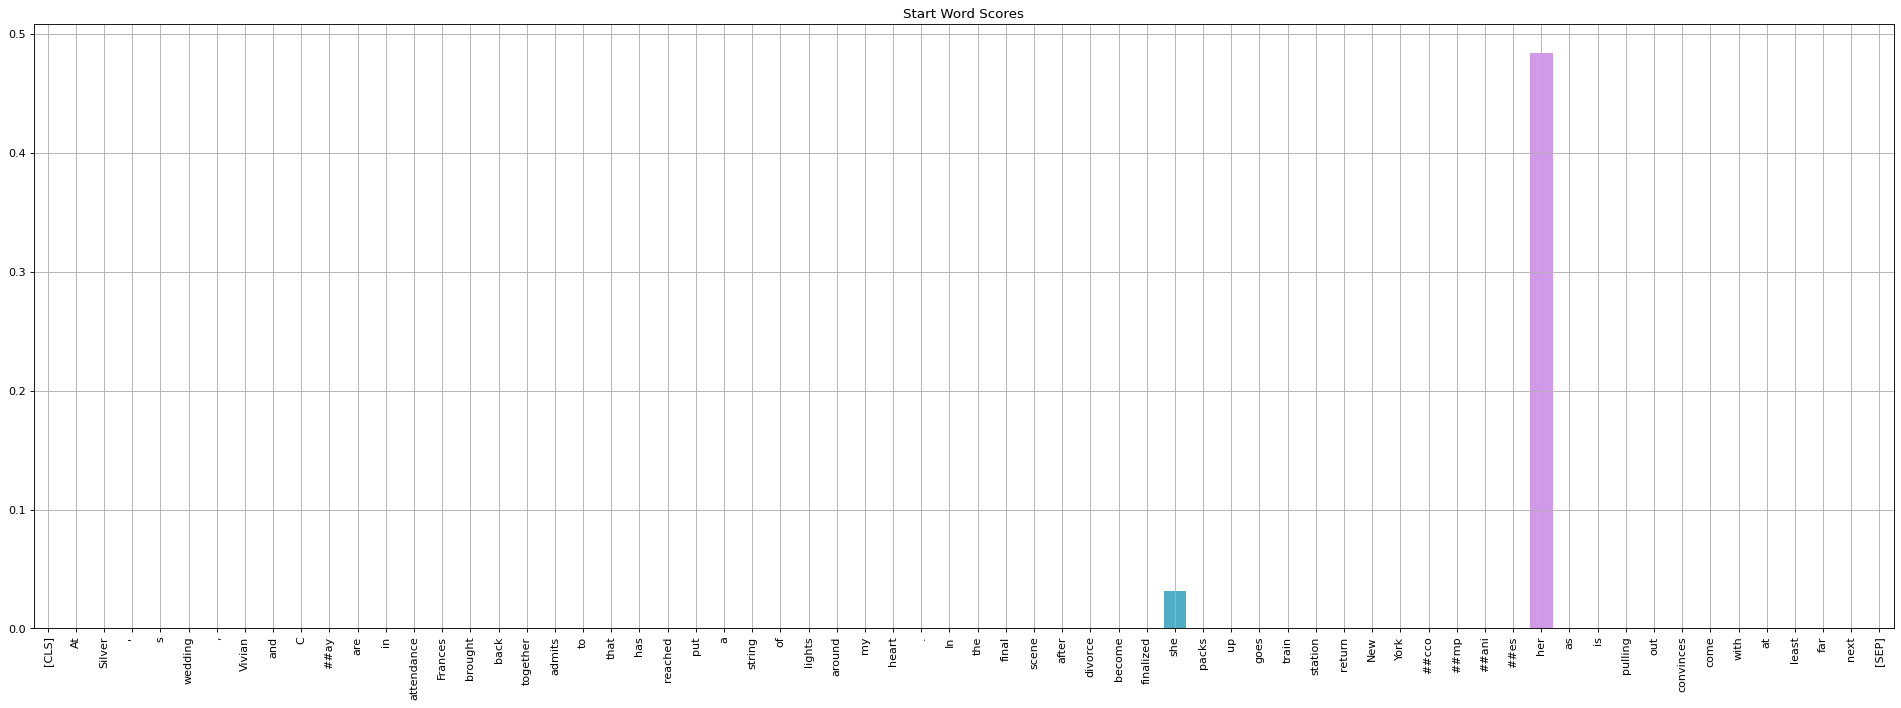

In [318]:
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

index = 171

figure(figsize=(30, 10), dpi=80)
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=tokens_labels[index], y=scores[index], ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

In [178]:
df_valid.iloc[87]

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              validation-88
text          Jenkins reaction to those comments saw him reach the semi final of the 2010 European Championship Darts, losing narrowly again to Phil Taylor in a classic 11-10, but showing a welcome return to form. Jenkins had a decent 2010 Grand Slam of Darts, beating Tony O'Shea in the 2nd round before succombing to a final leg

In [203]:
tokens_labels[98]

['[CLS]',
 'In',
 '1924',
 'Arthur',
 'Raymond',
 'Hi',
 '##bbe',
 '##rt',
 'was',
 'born',
 'in',
 'End',
 '##er',
 '##by',
 ',',
 'Leicestershire',
 ',',
 'the',
 'son',
 'of',
 'Canon',
 'H',
 '.',
 'V',
 '.',
 'Hi',
 '##bbe',
 '##rt',
 '(',
 'd',
 '.',
 '1980',
 ')',
 'and',
 'his',
 'wife',
 'Maud',
 '##e',
 ',',
 'and',
 'was',
 'educated',
 'at',
 'Ra',
 '##dley',
 'College',
 ',',
 'before',
 'he',
 'went',
 'up',
 'to',
 'Or',
 '##iel',
 'College',
 'at',
 'the',
 'University',
 'of',
 'Oxford',
 '.',
 'He',
 'was',
 'awarded',
 'the',
 'degrees',
 'of',
 'B',
 '.',
 'A',
 '.',
 'and',
 'later',
 'MA',
 '.',
 'He',
 'left',
 'Or',
 '##iel',
 'College',
 'to',
 'join',
 'the',
 'Army',
 ',',
 'where',
 'a',
 'sergeant',
 'major',
 'referred',
 'to',
 'Hi',
 '##bbe',
 '##rt',
 'as',
 'Christopher',
 'Robin',
 'based',
 'upon',
 'his',
 'youthful',
 'looks',
 '.',
 '[SEP]']

In [186]:
valid_ds[87][0][104]

1140

In [187]:
tokenizer.convert_ids_to_tokens(1140)

'him'

In [22]:
pred = output.view(-1, output.shape[-1])
labels = labels.view(-1)

In [23]:
mask = labels != 0

In [24]:
# l = labels[mask].tolist() 
l = labels[mask]
len(l)

195

In [25]:
pred = pred.argmax(1)
# p = pred[mask].tolist()
p = pred[mask]

In [26]:
(p == l).sum().item()

174

In [31]:
# ! pip install torchmetrics

In [41]:
# Utility function taken from the 'evaluate.py' script
def flat_list(l: List[List[Any]]) -> List[Any]:
    """
    Returns
    -------
        A single list containing all elements that
        were in the input list.
        
    Parameters
    ----------
    l: List[List[Any]]
        A list of lists of any type
    """
    return [_e for e in l for _e in e]

In [46]:
from torchmetrics import F1Score

f1 = F1Score(3)
f1(torch.tensor(flat_list(y_pred_list)), torch.tensor(flat_list(y_true_list)))

tensor(0.9973)

In [ ]:
epoch = 1
epochs = 10
s = 0.00001
print('-' * 17)
print(f"| LR: {s:.3e} |")
print(f'| epoch {epoch+1:>3d}/{epochs:<3d} |')

-----------------
| LR: 1.000e-05 |
| epoch   2/10  |


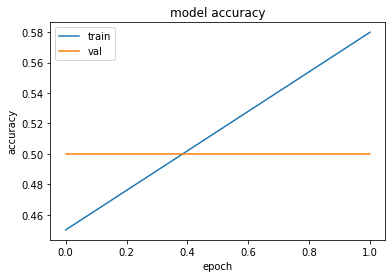

In [ ]:
from matplotlib import pyplot as plt
plt.plot(metrics_history['train_acc'])
plt.plot(metrics_history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from transformers import get_linear_schedule_with_warmup


scheduler = get_linear_schedule_with_warmup()

TypeError: get_linear_schedule_with_warmup() missing 3 required positional arguments: 'optimizer', 'num_warmup_steps', and 'num_training_steps'

In [ ]:
model_resumed = GAPModel(model_name_or_path).to(device, non_blocking=True)
optimizer_resumed = torch.optim.Adam(model_resumed.parameters())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
path = "../../model/checkpoints/my_model_861_6.pth"

In [ ]:
checkpoint = torch.load(path, map_location=device)
model_resumed.load_state_dict(checkpoint['model_state_dict'])
optimizer_resumed.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# del checkpoint

In [ ]:
optimizer_resumed

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 5e-06
    lr: 2.5e-06
    maximize: False
    weight_decay: 0
)

In [ ]:
len(checkpoint['scheduler_state_dict'])

8

In [ ]:
scheduler_resumed = torch.optim.lr_scheduler.StepLR(optimizer_resumed, step_size=4, gamma=0.5)

In [ ]:
scheduler_resumed.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
import glob
directory = "../../model/checkpoints/*.pth"
files = glob.glob(directory)

for file in files:
    print(file)
    print(file[-9:-4])

../../model/checkpoints\my_model_861_6.pth
861_6


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(train_ds[0][0])
# tokens[train_ds[0][1][0] - 1]
train_ds[0][1]

[41, 42, 44, 44, 61]

In [ ]:
tokens[42:44]

['cheryl', 'cassidy']

A List with your predictions.

Each prediction is a tuple, composed by two tuples:
(ambigous_pronoun, ambiguous_pronoun_offset), (coreferent_entity, coreferent_entity_offset))

for example:
    [(('her', 274), ('Pauline', 418))]

I need to know the original positions.

The model return the label prediction (0 1 2)

If pred == 0 => A

elif pred == 1 => B

else => --

I have to know:
1. The pronoun and its pos
2. The predicted entity and its pos


1. I can retrieve the pronoun through the last offset in offsets after encoding the ids.
    I also need its original position.
    
2. 
    


In [ ]:
def read_dataset(path: str) -> List[Dict]:
    samples: List[Dict] = []
    pron_counter = Counter()
    with open(path) as f:
        next(f)
        for line in f:
            (
                id,
                text,
                pron,
                p_offset,
                entity_A,
                offset_A,
                is_coref_A,
                entity_B,
                offset_B,
                is_coref_B,
                url,
            ) = line.strip().split("\t")
            pron_counter[pron.lower()] += 1
            samples.append(
                {
                    "id": id,
                    "text": text,
                    "pron": pron,
                    "p_offset": int(p_offset),
                    "entity_A": entity_A,
                    "offset_A": int(offset_A),
                    "is_coref_A": is_coref_A,
                    "entity_B": entity_B,
                    "offset_B": int(offset_B),
                    "is_coref_B": is_coref_B,
                    "url": url,
                }
            )
    print(pron_counter)
    return samples, pron_counter

In [ ]:
train_path = "../../model/data/train.tsv"
valid_path = "../../model/data/dev.tsv"

In [ ]:
train_dataset, train_pron_counter = read_dataset(train_path)
valid_dataset, valid_pron_counter = read_dataset(valid_path)

Counter({'his': 904, 'her': 773, 'he': 610, 'she': 555, 'him': 157})
Counter({'her': 140, 'his': 108, 'he': 93, 'she': 87, 'him': 26})


In [ ]:
train_dataset[0]

{'id': 'train-1',
 'text': "Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'pron': 'her',
 'p_offset': 274,
 'entity_A': 'Cheryl Cassidy',
 'offset_A': 191,
 'is_coref_A': 'TRUE',
 'entity_B': 'Pauline',
 'offset_B': 207,
 'is_coref_B': 'FALSE',
 'url': 'http://en.wikipedia.org/wiki/List_of_Teachers_(UK_TV_series)_characters'}

In [ ]:
def get_entity_and_offset_from_id(label_id, sentence):
    if label_id == 0: # Entity A
        return sentence['entity_A'], sentence['offset_A']
    elif label_id == 1: # Entity B
        return sentence['entity_B'], sentence['offset_B']
    else: # Neither
        return None, None 

In [ ]:
get_entity_and_offset_from_id(2, train_dataset[0])

(None, None)

In [ ]:
def predict(model, sentences: List[Dict]) -> List[Tuple[Tuple[str, int], Tuple[str, int]]]:
    df = pd.DataFrame(sentences)
    
    # tokenizer will be self.tokenizer in the final implementation
    dataset = GAPDataset(df, tokenizer)
    collator = Collator(device)

    predictions = []
    
    #self.model.eval()
    model.eval()
    with torch.no_grad():
        dataloader = DataLoader(dataset, batch_size=1, 
                                collate_fn=collator, shuffle=False)
        
        for (features, offsets, labels), sentence in zip(dataloader, sentences):
            
#             predictions = self.model(features, offsets).argmax(1).item()
            predicted_label_id = model(features, offsets).argmax(1).item()
            pred_entity, pred_entity_offset = get_entity_and_offset_from_id(predicted_label_id, sentence)
            pron, pron_offset = sentence['pron'],  sentence['p_offset']
            
            predictions.append(((pron, pron_offset), (pred_entity, pred_entity_offset)))
            
    return predictions
            

In [ ]:
pred = predict(model_resumed, valid_dataset)

In [ ]:
gold_values = []
for sentence in valid_dataset:
    gold_both_wrong = sentence["is_coref_A"] == "FALSE" and sentence["is_coref_B"] == "FALSE"
    if gold_both_wrong:
        gold_entity_offset = None
        gold_entity = None
    else:
        gold_entity_offset = (
            sentence["offset_A"] if sentence["is_coref_A"] == "TRUE" else sentence["offset_B"]
        )
        gold_entity = (
            sentence["entity_A"] if sentence["is_coref_A"] == "TRUE" else sentence["entity_B"]
        )
    
    
    gold_values.append(((sentence['pron'], sentence['p_offset']),(gold_entity, gold_entity_offset)))

In [ ]:
a = {}

a.setdefault("age", 0)
a.setdefault("age", 5)

0

In [ ]:
a['a'] = 0
a

{'age': 0, 'a': 0}

In [ ]:
wrong = []
for p, g in zip(pred, gold_values):
    if g[1][0] != p[1][0]:
        wrong.append((g, p))
#     print(p[1], g[1])

In [ ]:
pr = wrong[0][0][0][0]
get_gender("she")

gender = {}

for pair in wrong:
    pr = pair[0][0][0]
    gender.setdefault(get_gender(pr.lower()), 0)
    gender[get_gender(pr.lower())] += 1 


In [ ]:
gender

{1: 35, 0: 34}

In [ ]:
valid_dataset[1]

{'id': 'validation-2',
 'text': "Kathleen Nott was born in Camberwell, London. Her father, Philip, was a lithographic printer, and her mother, Ellen, ran a boarding house in Brixton; Kathleen was their third daughter. She was educated at Mary Datchelor Girls' School (now closed), London, before attending King's College, London.",
 'pron': 'She',
 'p_offset': 185,
 'entity_A': 'Ellen',
 'offset_A': 110,
 'is_coref_A': 'FALSE',
 'entity_B': 'Kathleen',
 'offset_B': 150,
 'is_coref_B': 'TRUE',
 'url': 'http://en.wikipedia.org/wiki/Kathleen_Nott'}

In [ ]:
def compute_metrics(predictions_s, samples):
    total = 0
    correct = 0
    for pred, label in zip(predictions_s, samples):
        gold_pron_offset = label["p_offset"]
        pred_pron_offset = pred[0][1] if len(pred[0]) > 0 else None
        gold_pron = label["pron"]
        pred_pron = pred[0][0] if len(pred[0]) > 0 else None
        gold_both_wrong = label["is_coref_A"] == "FALSE" and label["is_coref_B"] == "FALSE"
        pred_entity_offset = pred[1][1] if len(pred[1]) > 0 else None
        pred_entity = pred[1][0] if len(pred[1]) > 0 else None
              
        if gold_both_wrong:
            if pred_entity is None and gold_pron_offset == pred_pron_offset and gold_pron == pred_pron:
                correct += 1
            total += 1
        else:
            gold_entity_offset = (
                label["offset_A"] if label["is_coref_A"] == "TRUE" else label["offset_B"]
            )
            gold_entity = (
                label["entity_A"] if label["is_coref_A"] == "TRUE" else label["entity_B"]
            )
            if (
                gold_pron_offset == pred_pron_offset
                and gold_pron == pred_pron
                and gold_entity_offset == pred_entity_offset
                and gold_entity == pred_entity
            ):
                correct += 1
            total += 1
    
    print(f"# instances: {total}")
    acc = float(correct) / total
    print(f"# accuracy: {acc:.4f}")

In [ ]:
compute_metrics(pred, valid_dataset)

# instances: 454
# accuracy: 0.8568


In [ ]:
from arguments import CustomTrainingArguments
a = CustomTrainingArguments(output_dir="c")

In [ ]:
a

CustomTrainingArguments(output_dir='c', resume_from_checkpoint=None, save_model=False, num_train_epochs=3, logging_steps=250, learning_rate=0.0005, grad_clipping=None, early_stopping=False, early_stopping_mode='max', early_stopping_patience=0)

In [ ]:
from arguments import CustomTrainingArguments

yaml_file = "./train.yaml"

# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)
    
arg = CustomTrainingArguments(**config['training_args'])

TypeError: __init__() got an unexpected keyword argument 'resume_from_checkpoint'

In [ ]:
print(arg)

CustomTrainingArguments(output_dir='../../model/checkpoints/', num_train_epochs=6, logging_steps=250, save_model=False, learning_rate=5e-06, grad_clipping=None, early_stopping=False, early_stopping_mode='max', early_stopping_patience=0)
